In [1]:
!pip install scikit-learn==1.1 --user

In [2]:
import sys
path_append = "../"
sys.path.append(path_append)  # Go up one directory from where you are.

In [3]:
import sklearn
sklearn.__version__

'1.1.0'

In [4]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
import numpy as np

from torch.utils.tensorboard import SummaryWriter

import seaborn as sns
pd.options.mode.chained_assignment = None


# Feature Engineering

In [5]:
'''
    TRD_DD : 날짜
    ISU_CD : 종목코드
    ISU_NM : 종목명
    TDD_CLSPRC : 종가
    TDD_OPNPRC : 시가
    TDD_HGPRC : 고가
    TDD_LWPRC : 저가
    MKTCAP : 시가총액
    ACC_TRDVOL : 거래량
    EPS : 
    PER : 
    BPS : 
    PBR : 
    DPS : 
    DVD_YLD : 
'''

'\n    TRD_DD : 날짜\n    ISU_CD : 종목코드\n    ISU_NM : 종목명\n    TDD_CLSPRC : 종가\n    TDD_OPNPRC : 시가\n    TDD_HGPRC : 고가\n    TDD_LWPRC : 저가\n    MKTCAP : 시가총액\n    ACC_TRDVOL : 거래량\n    EPS : \n    PER : \n    BPS : \n    PBR : \n    DPS : \n    DVD_YLD : \n'

In [6]:
# 1. 날짜는 현재->과거순으로 정렬되어있음
# 2. EPS 부터는 NAN값이 존재.
# 3. 종가, 시가, 고가, 저가, 시가총액, 거래량은 문자열로 되어있음
for data_file in os.listdir(path_append + "../data/KR_Data/Data/")[:3]:
    data_file = data_file[:-4]
    tmp_df = pd.read_csv(path_append + f"../data/KR_Data/Data/{data_file}.csv")
    display(tmp_df.head(3))

,TRD_DD,ISU_CD,ISU_NM,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,ACC_TRDVOL,EPS,PER,BPS,PBR,DPS,DVD_YLD
0,2022/01/11,900110,이스트아시아홀딩스,145,150,151,143,"24,719,670,905","4,147,345",NaN,NaN,NaN,NaN,NaN,NaN
1,2022/01/10,900110,이스트아시아홀딩스,150,152,155,149,"25,572,073,350","2,628,028",NaN,NaN,NaN,NaN,NaN,NaN
2,2022/01/07,900110,이스트아시아홀딩스,151,158,162,148,"25,742,553,839","7,561,654",NaN,NaN,NaN,NaN,NaN,NaN


,TRD_DD,ISU_CD,ISU_NM,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,ACC_TRDVOL,EPS,PER,BPS,PBR,DPS,DVD_YLD
0,2022/01/11,900270,헝셩그룹,460,481,482,456,"36,800,000,000","747,302",NaN,NaN,NaN,NaN,NaN,NaN
1,2022/01/10,900270,헝셩그룹,485,490,500,469,"38,800,000,000","852,598",NaN,NaN,NaN,NaN,NaN,NaN
2,2022/01/07,900270,헝셩그룹,485,513,537,478,"38,800,000,000","2,468,506",NaN,NaN,NaN,NaN,NaN,NaN


,TRD_DD,ISU_CD,ISU_NM,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,ACC_TRDVOL,EPS,PER,BPS,PBR,DPS,DVD_YLD
0,2022/01/11,900260,로스웰,548,592,600,511,"98,725,730,764","58,874,006",NaN,NaN,NaN,NaN,NaN,NaN
1,2022/01/10,900260,로스웰,595,652,681,586,"107,193,083,585","47,913,246",NaN,NaN,NaN,NaN,NaN,NaN
2,2022/01/07,900260,로스웰,658,913,925,658,"118,542,939,494","171,463,169",NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# data파일과 preprocessed 파일 merge
data_df = pd.read_csv(path_append + "../data/KR_Data/Data/HK0000057197.csv")
preprocessed_df = pd.read_csv(path_append + "../data/KR_Data/Preprocessed/HK0000057197_preprocessed.csv")
total_df = pd.merge(data_df, preprocessed_df, on="TRD_DD")
total_df

,TRD_DD,ISU_CD,ISU_NM,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,ACC_TRDVOL,EPS,...,BPS,PBR,DPS,DVD_YLD,GDC_sig,RSI_sig,ROC_sig,MAP_sig,STC_sig,TREND
0,2022/01/11,900110,이스트아시아홀딩스,145,150,151,143,"24,719,670,905","4,147,345",NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN
1,2022/01/10,900110,이스트아시아홀딩스,150,152,155,149,"25,572,073,350","2,628,028",NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN
2,2022/01/07,900110,이스트아시아홀딩스,151,158,162,148,"25,742,553,839","7,561,654",NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN
3,2022/01/06,900110,이스트아시아홀딩스,158,172,186,156,"26,935,917,262","22,931,278",NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN
4,2022/01/05,900110,이스트아시아홀딩스,171,164,187,161,"29,152,163,619","29,419,967",NaN,...,NaN,NaN,NaN,NaN,0,0,-1,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2887,2010/04/29,900110,동아체육용품,"3,460","3,700","3,740","3,430","79,580,000,000","1,170,700",NaN,...,NaN,NaN,NaN,NaN,0,0,-1,1,0,0.454545
2888,2010/04/28,900110,동아체육용품,"3,700","3,700","3,970","3,660","85,100,000,000","1,422,838",NaN,...,NaN,NaN,NaN,NaN,0,0,-1,1,0,0.636364
2889,2010/04/27,900110,동아체육용품,"3,750","3,885","3,930","3,745","86,250,000,000","1,385,013",NaN,...,NaN,NaN,NaN,NaN,0,0,-1,1,0,0.818182
2890,2010/04/26,900110,동아체육용품,"3,860","3,655","4,055","3,650","88,780,000,000","4,312,630",NaN,...,NaN,NaN,NaN,NaN,0,0,-1,1,1,1.000000


In [8]:
# 날짜 과거->현재순으로 변경
total_df = total_df[::-1].reset_index(drop=True)

# 연, 월, 일을 구분하여 3개의 컬럼으로 생성
total_df[["Y", "M", "D"]] = total_df["TRD_DD"].str.split("/", expand=True)
total_df = total_df.drop("TRD_DD", axis=1)
total_df = total_df[total_df.columns[-3:].to_list()+total_df.columns[:-3].to_list()]
total_df[:3]

,Y,M,D,ISU_CD,ISU_NM,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,...,BPS,PBR,DPS,DVD_YLD,GDC_sig,RSI_sig,ROC_sig,MAP_sig,STC_sig,TREND
0,2010,04,23,900110,동아체육용품,"3,825","4,500","4,500","3,825","87,975,000,000",...,NaN,NaN,NaN,NaN,0,0,-1,1,0,NaN
1,2010,04,26,900110,동아체육용품,"3,860","3,655","4,055","3,650","88,780,000,000",...,NaN,NaN,NaN,NaN,0,0,-1,1,1,1.000000
2,2010,04,27,900110,동아체육용품,"3,750","3,885","3,930","3,745","86,250,000,000",...,NaN,NaN,NaN,NaN,0,0,-1,1,0,0.818182


In [9]:
# Create a new 'Date' column by combining 'Y', 'M', 'D' columns
total_df['Date'] = pd.to_datetime(total_df[['Y', 'M', 'D']].rename(columns={'Y': 'year', 'M': 'month', 'D': 'day'}))

# Set 'Date' as the index
total_df.set_index('Date', inplace=True)

# Create a 'count_day' column that represents the number of days from the first date
total_df['count_day'] = (total_df.index - total_df.index.min()).days

# Drop the 'Y', 'M', 'Day' columns as they're no longer needed
total_df.drop(columns=['Y', 'M', 'D'], inplace=True)

# Reorder the columns to make 'count_day' first
cols = ['count_day'] + [col for col in total_df.columns if col != 'count_day']
total_df = total_df[cols]

total_df.head()


,count_day,ISU_CD,ISU_NM,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,ACC_TRDVOL,EPS,...,BPS,PBR,DPS,DVD_YLD,GDC_sig,RSI_sig,ROC_sig,MAP_sig,STC_sig,TREND
Date,,,,,,,,,,,,,,,,,,,,,
2010-04-23,0,900110,동아체육용품,"3,825","4,500","4,500","3,825","87,975,000,000","6,399,130",NaN,...,NaN,NaN,NaN,NaN,0,0,-1,1,0,NaN
2010-04-26,3,900110,동아체육용품,"3,860","3,655","4,055","3,650","88,780,000,000","4,312,630",NaN,...,NaN,NaN,NaN,NaN,0,0,-1,1,1,1.000000
2010-04-27,4,900110,동아체육용품,"3,750","3,885","3,930","3,745","86,250,000,000","1,385,013",NaN,...,NaN,NaN,NaN,NaN,0,0,-1,1,0,0.818182
2010-04-28,5,900110,동아체육용품,"3,700","3,700","3,970","3,660","85,100,000,000","1,422,838",NaN,...,NaN,NaN,NaN,NaN,0,0,-1,1,0,0.636364
2010-04-29,6,900110,동아체육용품,"3,460","3,700","3,740","3,430","79,580,000,000","1,170,700",NaN,...,NaN,NaN,NaN,NaN,0,0,-1,1,0,0.454545


In [10]:
total_df.drop(['ISU_CD'], axis=1, inplace=True)


In [11]:
total_df["ISU_NM"] = total_df["ISU_NM"].astype(str)

# Create one-hot vectors
total_df = pd.get_dummies(total_df, columns=["ISU_NM"])


In [12]:
total_df

,count_day,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,ACC_TRDVOL,EPS,PER,BPS,...,DVD_YLD,GDC_sig,RSI_sig,ROC_sig,MAP_sig,STC_sig,TREND,ISU_NM_동아체육용품,ISU_NM_이스트아시아스포츠,ISU_NM_이스트아시아홀딩스
Date,,,,,,,,,,,,,,,,,,,,,
2010-04-23,0,"3,825","4,500","4,500","3,825","87,975,000,000","6,399,130",NaN,NaN,NaN,...,NaN,0,0,-1,1,0,NaN,1,0,0
2010-04-26,3,"3,860","3,655","4,055","3,650","88,780,000,000","4,312,630",NaN,NaN,NaN,...,NaN,0,0,-1,1,1,1.000000,1,0,0
2010-04-27,4,"3,750","3,885","3,930","3,745","86,250,000,000","1,385,013",NaN,NaN,NaN,...,NaN,0,0,-1,1,0,0.818182,1,0,0
2010-04-28,5,"3,700","3,700","3,970","3,660","85,100,000,000","1,422,838",NaN,NaN,NaN,...,NaN,0,0,-1,1,0,0.636364,1,0,0
2010-04-29,6,"3,460","3,700","3,740","3,430","79,580,000,000","1,170,700",NaN,NaN,NaN,...,NaN,0,0,-1,1,0,0.454545,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-05,4275,171,164,187,161,"29,152,163,619","29,419,967",NaN,NaN,NaN,...,NaN,0,0,-1,0,0,NaN,0,0,1
2022-01-06,4276,158,172,186,156,"26,935,917,262","22,931,278",NaN,NaN,NaN,...,NaN,0,0,0,0,0,NaN,0,0,1
2022-01-07,4277,151,158,162,148,"25,742,553,839","7,561,654",NaN,NaN,NaN,...,NaN,0,0,0,0,0,NaN,0,0,1


In [13]:
# EPS, PER, BPS, PBR, DPS, DVD_YLD는 사용불가능하므로 제거
print(total_df["EPS"].dropna())
print(total_df["PER"].dropna())
print(total_df["BPS"].dropna())
print(total_df["PBR"].dropna())
print(total_df["DPS"].dropna())
print(total_df["DVD_YLD"].dropna())

# 종목명(ISU_NM)은 같은 종목 코드이더라도 달라질 수 있으나, 무의미하므로 제거
total_df = total_df.drop(["EPS", "PER", "BPS", "PBR", "DPS", "DVD_YLD"], axis=1)
# total_df = total_df.drop(["EPS", "PER", "BPS", "PBR", "DPS", "DVD_YLD", "ISU_NM"], axis=1)
total_df

Series([], Name: EPS, dtype: float64)
Series([], Name: PER, dtype: float64)
Series([], Name: BPS, dtype: float64)
Series([], Name: PBR, dtype: float64)
Series([], Name: DPS, dtype: float64)
Series([], Name: DVD_YLD, dtype: float64)


,count_day,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,ACC_TRDVOL,GDC_sig,RSI_sig,ROC_sig,MAP_sig,STC_sig,TREND,ISU_NM_동아체육용품,ISU_NM_이스트아시아스포츠,ISU_NM_이스트아시아홀딩스
Date,,,,,,,,,,,,,,,,
2010-04-23,0,"3,825","4,500","4,500","3,825","87,975,000,000","6,399,130",0,0,-1,1,0,NaN,1,0,0
2010-04-26,3,"3,860","3,655","4,055","3,650","88,780,000,000","4,312,630",0,0,-1,1,1,1.000000,1,0,0
2010-04-27,4,"3,750","3,885","3,930","3,745","86,250,000,000","1,385,013",0,0,-1,1,0,0.818182,1,0,0
2010-04-28,5,"3,700","3,700","3,970","3,660","85,100,000,000","1,422,838",0,0,-1,1,0,0.636364,1,0,0
2010-04-29,6,"3,460","3,700","3,740","3,430","79,580,000,000","1,170,700",0,0,-1,1,0,0.454545,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-05,4275,171,164,187,161,"29,152,163,619","29,419,967",0,0,-1,0,0,NaN,0,0,1
2022-01-06,4276,158,172,186,156,"26,935,917,262","22,931,278",0,0,0,0,0,NaN,0,0,1
2022-01-07,4277,151,158,162,148,"25,742,553,839","7,561,654",0,0,0,0,0,NaN,0,0,1


In [14]:
# 문자열을 숫자로 변경
for i, col in enumerate(["TDD_CLSPRC", "TDD_OPNPRC", "TDD_HGPRC", "TDD_LWPRC", "MKTCAP", "ACC_TRDVOL"]):
    total_df[col] = total_df[col].str.replace(pat=r'[^0-9]', repl=r'' ,regex=True).apply(pd.to_numeric)
total_df

,count_day,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,ACC_TRDVOL,GDC_sig,RSI_sig,ROC_sig,MAP_sig,STC_sig,TREND,ISU_NM_동아체육용품,ISU_NM_이스트아시아스포츠,ISU_NM_이스트아시아홀딩스
Date,,,,,,,,,,,,,,,,
2010-04-23,0,3825,4500,4500,3825,87975000000,6399130,0,0,-1,1,0,NaN,1,0,0
2010-04-26,3,3860,3655,4055,3650,88780000000,4312630,0,0,-1,1,1,1.000000,1,0,0
2010-04-27,4,3750,3885,3930,3745,86250000000,1385013,0,0,-1,1,0,0.818182,1,0,0
2010-04-28,5,3700,3700,3970,3660,85100000000,1422838,0,0,-1,1,0,0.636364,1,0,0
2010-04-29,6,3460,3700,3740,3430,79580000000,1170700,0,0,-1,1,0,0.454545,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-05,4275,171,164,187,161,29152163619,29419967,0,0,-1,0,0,NaN,0,0,1
2022-01-06,4276,158,172,186,156,26935917262,22931278,0,0,0,0,0,NaN,0,0,1
2022-01-07,4277,151,158,162,148,25742553839,7561654,0,0,0,0,0,NaN,0,0,1


In [15]:
total_df = total_df.fillna(0)

# 1) -1, 0, 1만 사용 -> -1, 0, 1의 비율은 불균형해짐
# -1, 0, 1 비율 = 76, 2740, 76
total_df.loc[((total_df["TREND"]!=-1) & (total_df["TREND"]!=0) & (total_df["TREND"]!=1)), "TREND"] = 0

# 2) 음수를 -1로, 양수를 1로 -> 너무 빈번하게 사고팜
# -1, 0, 1 비율 = 1397: 1440, 55
total_df.loc[total_df["TREND"]<0, "TREND"] = -1
total_df.loc[total_df["TREND"]>0, "TREND"] = 1

# 3) -0.5보다 작으면 -1, 0.5보다 크면 1, 아니면 0
# -1, 0, 1 비율 = 752: 1409, 731

total_df.loc[total_df["TREND"]<=-0.5, "TREND"] = -1
total_df.loc[total_df["TREND"]>=0.5, "TREND"] = 1
total_df.loc[(total_df["TREND"]<0.5) & (total_df["TREND"]>-0.5), "TREND"] = 0
print(set(total_df["TREND"]))
print(total_df["TREND"].value_counts())

{0.0, 1.0, -1.0}
 0.0    2740
 1.0      76
-1.0      76
Name: TREND, dtype: int64


In [16]:
total_df["TREND"] += 1

In [17]:
total_df["TREND"] = total_df["TREND"].convert_dtypes(int)
total_df["TREND"]

Date
2010-04-23    1
2010-04-26    2
2010-04-27    1
2010-04-28    1
2010-04-29    1
             ..
2022-01-05    1
2022-01-06    1
2022-01-07    1
2022-01-10    1
2022-01-11    1
Name: TREND, Length: 2892, dtype: Int64

In [18]:
# GDC, RSI, ROC, MAP, STC
# 파일별로 분포가 다르게 나옴.
# 추후에 빼는 것도 고려가능

# tmp_df = pd.read_csv("../data/KR_Data/Preprocessed/HK0000214814_preprocessed.csv")
# tmp_df = pd.read_csv("../data/KR_Data/Preprocessed/HK0000295359_preprocessed.csv")
tmp_df = pd.read_csv(path_append + "../data/KR_Data/Preprocessed/HK0000307485_preprocessed.csv")
print(tmp_df["GDC_sig"].value_counts())
print(tmp_df["RSI_sig"].value_counts())
print(tmp_df["ROC_sig"].value_counts())
print(tmp_df["MAP_sig"].value_counts())
print(tmp_df["STC_sig"].value_counts())

 0    1218
 1      33
-1      33
Name: GDC_sig, dtype: int64
 0    1241
 1      39
-1       4
Name: RSI_sig, dtype: int64
-1    942
 1    275
 0     67
Name: ROC_sig, dtype: int64
0    1284
Name: MAP_sig, dtype: int64
 0    1121
 1      97
-1      66
Name: STC_sig, dtype: int64


In [19]:
# 수치형 데이터 minmax 정규화
mm = MinMaxScaler()
sc = RobustScaler()
for col in ["count_day", "TDD_CLSPRC", "TDD_OPNPRC", "TDD_HGPRC", "TDD_LWPRC"]:
    total_df[col] = mm.fit_transform(total_df[col].values.reshape(-1,1))
for col in ["MKTCAP", "ACC_TRDVOL"]:
    total_df[col] = sc.fit_transform(total_df[col].values.reshape(-1,1))
total_df

,count_day,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,ACC_TRDVOL,GDC_sig,RSI_sig,ROC_sig,MAP_sig,STC_sig,TREND,ISU_NM_동아체육용품,ISU_NM_이스트아시아스포츠,ISU_NM_이스트아시아홀딩스
Date,,,,,,,,,,,,,,,,
2010-04-23,0.000000,0.636128,0.743802,0.708661,0.668706,1.022974,8.217196,0,0,-1,1,0,1,1,0,0
2010-04-26,0.000701,0.642178,0.604132,0.638583,0.638112,1.044350,5.455601,0,0,-1,1,1,2,1,0,0
2010-04-27,0.000934,0.623163,0.642149,0.618898,0.654720,0.977169,1.580743,0,0,-1,1,0,1,1,0,0
2010-04-28,0.001168,0.614520,0.611570,0.625197,0.639860,0.946633,1.630807,0,0,-1,1,0,1,1,0,0
2010-04-29,0.001402,0.573034,0.611570,0.588976,0.599650,0.800058,1.297088,0,0,-1,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-05,0.998598,0.004494,0.027107,0.029449,0.028147,-0.538974,38.686507,0,0,-1,0,0,1,0,0,1
2022-01-06,0.998832,0.002247,0.028430,0.029291,0.027273,-0.597823,30.098380,0,0,0,0,0,1,0,0,1
2022-01-07,0.999066,0.001037,0.026116,0.025512,0.025874,-0.629511,9.755859,0,0,0,0,0,1,0,0,1


In [20]:
# TREND값이 너무 discrete하여 모델이 정확하게 예측하는데 어려움이 있을 수 있음.

import plotly.graph_objects as go
import plotly.express as px
fig = go.Figure()
fig.add_trace(go.Line(x=total_df.index, y=total_df["MKTCAP"], name="stay"))
fig.add_trace(go.Scatter(x=total_df[total_df["TREND"]<0].index, y=total_df[total_df["TREND"]<0]["MKTCAP"], name="buy", mode="markers"))
fig.add_trace(go.Scatter(x=total_df[total_df["TREND"]>0].index, y=total_df[total_df["TREND"]>0]["MKTCAP"], name="sell", mode="markers"))
fig.update_layout(
    title='Stock Label',
    xaxis=dict(title='Time'),
    yaxis=dict(title='Price')
)

c:\ProgramData\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




<Axes: xlabel='Date', ylabel='MKTCAP'>

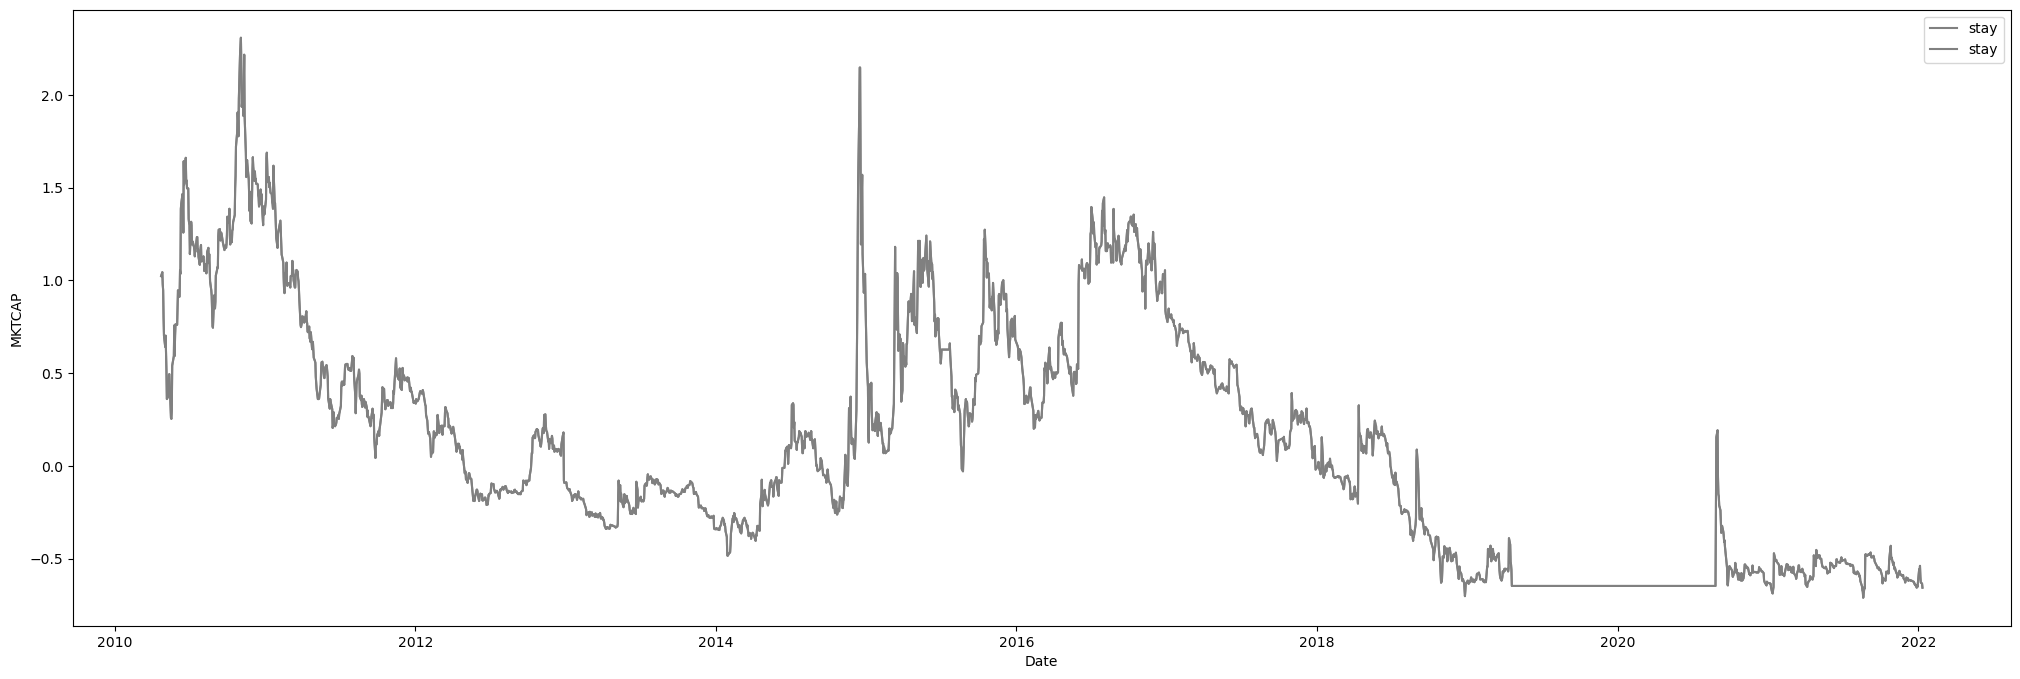

In [21]:
# TREND값이 너무 discrete하여 모델이 정확하게 예측하는데 어려움이 있을 수 있음.

plt.figure(figsize=(25,8))
sns.lineplot(x=total_df.index, y=total_df["MKTCAP"], label="stay", color = "gray")
sns.lineplot(data=total_df, x=total_df.index, y="MKTCAP", label="stay", color="gray")
# total_df_reset = total_df.reset_index()
# sns.lineplot(data=total_df_reset, x='index', y="MKTCAP", label="stay", color="gray")

# sns.lineplot(total_df.index, total_df["MKTCAP"], label="stay", color = "gray")
# sns.scatterplot(total_df[total_df["TREND"]<0].index, total_df[total_df["TREND"]<0]["MKTCAP"], label="buy", color="blue")
# sns.scatterplot(total_df[total_df["TREND"]>0].index, total_df[total_df["TREND"]>0]["MKTCAP"], label="sell", color="red")

# 결론 및 사용법

In [22]:
'''
    - 데이터 개요
        전처리된 데이터 : total_df
        범주형 컬럼 : Y, M, D, ISU_CD, GDC_sig, RSI_sig, ROC_sig, MAP_sig, STC_sig
        수치형 컬럼 : TDD_CLSPRC, TDD_OPNPRC, TDD_HGPRC, TDD_LWPRC, MKTCAP, ACC_TRDVOL
        레이블 : TREND

    - 고려사항 :
        1) 범주형 데이터는 embedding 사용하여 학습 권장
        2) 레이블
            NAN값 0으로 처리함.

            2-1) 레이블처리 
                : -1, 0, 1을 어떻게 둘지 정의에 따라 다름
                ● -1, 0, 1 분류
                    공통적으로, 레이블이 discrete 한 문제가 있음
                    (1) 0보다 작은경우를 모두 -1, 큰경우를 1
                        # -1, 0, 1 비율 = 1397: 1440, 55
                        : 너무 빈번하게 거래함.

                    (2) -1, 0, 1만 사용 
                        # -1, 0, 1 비율 = 76, 2740, 76
                        : 그래프상에서 사야할 때 안사는 경우 발생 가능, 모델이 정확하게 예측하는데 어려움이 있을 수 있음.
                        
                    (3) -0.5보다 작으면 -1, 0.5보다 크면 1, 아니면 0 
                        # -1, 0, 1 비율 = 752: 1409, 731
                        : (현재 전처리 상태) 어느정도 비율이 맞음

                ● 회귀
                    : 레이블을 그대로 둠
                    (1) 모델이 회귀를 하고, 얼마나 상승할지, 하락할지를 통해 사고 팔지를 결정하도록 가능

        3) GDC, RSI, ROC, MAP, STC은 학습에 도움이 될지는 미지수
'''

'\n    - 데이터 개요\n        전처리된 데이터 : total_df\n        범주형 컬럼 : Y, M, D, ISU_CD, GDC_sig, RSI_sig, ROC_sig, MAP_sig, STC_sig\n        수치형 컬럼 : TDD_CLSPRC, TDD_OPNPRC, TDD_HGPRC, TDD_LWPRC, MKTCAP, ACC_TRDVOL\n        레이블 : TREND\n\n    - 고려사항 :\n        1) 범주형 데이터는 embedding 사용하여 학습 권장\n        2) 레이블\n            NAN값 0으로 처리함.\n\n            2-1) 레이블처리 \n                : -1, 0, 1을 어떻게 둘지 정의에 따라 다름\n                ● -1, 0, 1 분류\n                    공통적으로, 레이블이 discrete 한 문제가 있음\n                    (1) 0보다 작은경우를 모두 -1, 큰경우를 1\n                        # -1, 0, 1 비율 = 1397: 1440, 55\n                        : 너무 빈번하게 거래함.\n\n                    (2) -1, 0, 1만 사용 \n                        # -1, 0, 1 비율 = 76, 2740, 76\n                        : 그래프상에서 사야할 때 안사는 경우 발생 가능, 모델이 정확하게 예측하는데 어려움이 있을 수 있음.\n                        \n                    (3) -0.5보다 작으면 -1, 0.5보다 크면 1, 아니면 0 \n                        # -1, 0, 1 비율 = 752: 1409, 731\n                        : (현재 전처리 상태) 어느정도 비율이 맞음\n

In [23]:
import torch
import random
class SequenceDataset(torch.utils.data.Dataset):
    def __init__(self, x, y, batch_size):
        self.x = []
        self.y = []
        n_mul = len(x)//batch_size
        n_rest = len(x)%batch_size
        
        for i in range(n_mul):
            idx = int(i * n_mul)
            x_seq = torch.tensor(x[idx: idx+batch_size], dtype = torch.float32)
            y_seq = torch.tensor(y[idx: idx+batch_size], dtype = torch.float32)
            self.x.append(x_seq)
            self.y.append(y_seq)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [24]:
y = total_df[['TREND']]
X = total_df.drop(['TREND'],axis=1)


In [25]:
y

,TREND
Date,
2010-04-23,1
2010-04-26,2
2010-04-27,1
2010-04-28,1
2010-04-29,1
...,...
2022-01-05,1
2022-01-06,1
2022-01-07,1


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, shuffle= False)

In [27]:
X_train = X_train.iloc[:, :].values 
X_test = X_test.iloc[:, :].values 
y_train = y_train.iloc[:, -1].values
y_test = y_test.iloc[:, -1].values

In [28]:
len(X_train[0])

15

In [29]:
import torch
from ccnets.config import get_parser
from ccnets.ccnets import CCNets
from ccnets.resnets import ResNets
from libs.supervised_networks.supervised_networks import SupervisedNetworks
from ccnets.utils.loader import save_dataset, load_dataset
from nn.transformer import TFEncoder, TFDecoder
from ccnets.utils.log import create_log_details, create_log_name
from ccnets.utils.setting import set_random_seed

from torch.utils.tensorboard import SummaryWriter

In [30]:
args = get_parser()
args.device = torch.device('cuda:0' if (torch.cuda.is_available() and args.ngpu > 0) else "cpu")

In [31]:
import IPython ; file_path = IPython.extract_module_locals()[1]['__vsc_ipynb_file__']
from pathlib import Path
file_name = Path(file_path).stem
model_path = path_append + f"models/{file_name}/"
temp_path = path_append + f"models/{'temp_'}{file_name}/"
log_path = path_append + f"log/{file_name}/"

if Path(temp_path).exists() is False: 
    os.mkdir(temp_path)

if Path(model_path).exists() is False: 
    os.mkdir(model_path)

if Path(log_path).exists() is False: 
    os.mkdir(log_path)  
    
args.model_path = model_path
args.temp_path = temp_path

In [32]:
batch_size = 64

In [33]:
data_path = path_append + f"data/custom_dataset/{file_name}/"
load_data = False
trainset = None
testset = None
if not os.path.isdir(data_path) or not load_data:
    trainset = SequenceDataset(X_train, y_train, batch_size)
    testset = SequenceDataset(X_test, y_test, batch_size)
    save_dataset(trainset, testset, data_path)
else:
    trainset, testset = load_dataset(data_path)

In [34]:
args.num_epoch = 2000
args.batch_size = batch_size
args.step_size = 10

args.num_layer = 3
args.hidden_size = 256
args.lr = 2e-4

args.obs_size = 15
args.label_size = 3
args.explain_size = 12
args.seq_len = 30

args.num_checkpoints = 50
args.use_one_hot = True

args.use_reasoner_swap_inputs = False
args.use_producer_swap_inputs = True

args.reasoner_joint_type = "none"
args.producer_joint_type = "none"

args.label_type = "UC" 

args.obs_fn = "none"
args.label_fn = "softmax"

args.use_report = True

In [35]:
args.loss_type = "L1"
args.error_type = "MSLE" 
args.loss_reduction = "layer"
args.error_reduction = "batch"

log_details = create_log_details(args)
args.log = SummaryWriter(log_dir=create_log_name(log_path, log_details))

set_random_seed(0)
ccnets = CCNets(args, TFEncoder, TFDecoder, TFDecoder)
ccnets.train(trainset, testset = testset)

  0%|          | 0/2000 [00:00<?, ?it/s]

[49/2000][0/1][Time 2.74]
Opt-Adam lr: 0.00019954042300537276
Inf: 0.0032	Gen: 0.3084	Rec: 0.3086	E: 0.0000	R: 0.0000	P: 0.2429
precision: 1.0000	recall: 1.0000	f1: 1.0000
[99/2000][0/1][Time 2.32]
Opt-Adam lr: 0.00019908190206581545
Inf: 0.0017	Gen: 0.2374	Rec: 0.2375	E: 0.0000	R: 0.0000	P: 0.1588
precision: 0.9744	recall: 0.6667	f1: 0.6533
[149/2000][0/1][Time 2.24]
Opt-Adam lr: 0.00019862443475463504
Inf: 0.0017	Gen: 0.1989	Rec: 0.1989	E: 0.0000	R: 0.0000	P: 0.1201
precision: 0.9744	recall: 0.6667	f1: 0.6533
[199/2000][0/1][Time 2.35]
Opt-Adam lr: 0.0001981680186507147
Inf: 0.0016	Gen: 0.1478	Rec: 0.1478	E: 0.0000	R: 0.0000	P: 0.0754
precision: 1.0000	recall: 1.0000	f1: 1.0000
[249/2000][0/1][Time 2.31]
Opt-Adam lr: 0.00019771265133850107
Inf: 0.0016	Gen: 0.1532	Rec: 0.1532	E: 0.0000	R: 0.0000	P: 0.0787
precision: 1.0000	recall: 1.0000	f1: 1.0000
[299/2000][0/1][Time 2.24]
Opt-Adam lr: 0.0001972583304079914
Inf: 0.0016	Gen: 0.1473	Rec: 0.1474	E: 0.0000	R: 0.0000	P: 0.0749
precision:

In [36]:
args.loss_type = "MSE"
args.loss_reduction = "all"

log_details = create_log_details(args)
args.log = SummaryWriter(log_dir=create_log_name(log_path, log_details))

set_random_seed(0)
resnets = ResNets(args, TFEncoder, TFDecoder)
resnets.train(trainset, testset = testset)

  0%|          | 0/2000 [00:00<?, ?it/s]

[49/2000][0/1][Time 0.57]
Opt-Adam lr: 0.00019954042300537276
Inf: 0.0314
precision: 1.0000	recall: 1.0000	f1: 1.0000
[99/2000][0/1][Time 0.62]
Opt-Adam lr: 0.00019908190206581545
Inf: 0.0298
precision: 0.9744	recall: 0.6667	f1: 0.6533
[149/2000][0/1][Time 0.59]
Opt-Adam lr: 0.00019862443475463504
Inf: 0.0257
precision: 0.9744	recall: 0.6667	f1: 0.6533
[199/2000][0/1][Time 0.61]
Opt-Adam lr: 0.0001981680186507147
Inf: 0.0281
precision: 1.0000	recall: 1.0000	f1: 1.0000
[249/2000][0/1][Time 0.60]
Opt-Adam lr: 0.00019771265133850107
Inf: 0.0318
precision: 1.0000	recall: 1.0000	f1: 1.0000
[299/2000][0/1][Time 0.62]
Opt-Adam lr: 0.0001972583304079914
Inf: 0.0272
precision: 1.0000	recall: 1.0000	f1: 1.0000
[349/2000][0/1][Time 0.59]
Opt-Adam lr: 0.00019680505345472094
Inf: 0.0228
precision: 0.9744	recall: 0.6667	f1: 0.6533
[399/2000][0/1][Time 0.59]
Opt-Adam lr: 0.00019635281807975005
Inf: 0.0316
precision: 1.0000	recall: 1.0000	f1: 1.0000
[449/2000][0/1][Time 0.61]
Opt-Adam lr: 0.0001959016